<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2273
0
len bboxes: 1


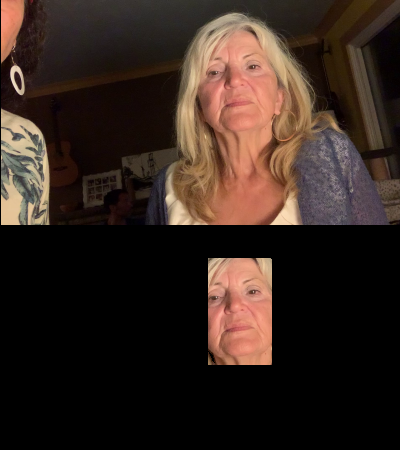

1
len bboxes: 1
nearest box used


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


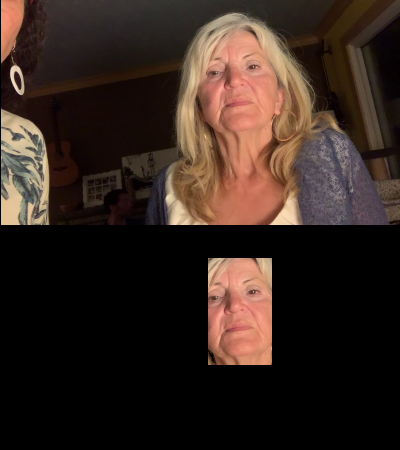

2
len bboxes: 1
nearest box used


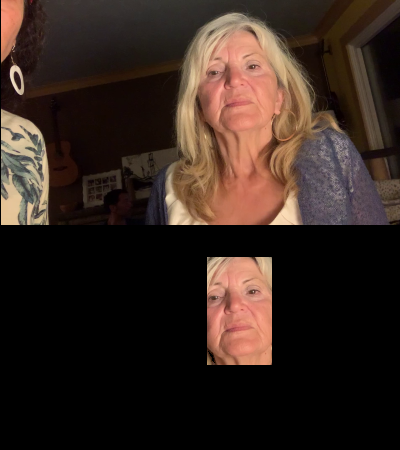

3
len bboxes: 1
nearest box used


In [ ]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
# construct the argument parse and parse the arguments

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
# if a video path was not supplied, grab the reference
# to the gray


camera = cv2.VideoCapture("IMG_4100.MOV")  
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(n_frames)

''''change this'''


ra = []
ga = []
ba = []
box = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
        frame = imutils.rotate(frame, 180)
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)

        bboxes = classifier.detectMultiScale(skin, 1.05, 8)
        print('len bboxes:', len(bboxes))
        if box == []:  
          if len(bboxes) ==0:
            print("face not detected in first frame")   ##change to an assert later
          else:
            box = bboxes[0]
#choose the box most like the last frame, if more than one box. If zero boxes, use box from last frame
        else:
          if len(bboxes) ==0:
            box = box   
            print("old box used") 
          else:
           test2 = np.zeros(len(bboxes))
           for i, boxnew in enumerate(bboxes):
            [xn, yn, widthn, heightn] = boxnew 
            x2n = xn + widthn
            y2n = yn + heightn
           	# draw a rectangle mask and compare to box from previous frame
            tempn = np.zeros([frame.shape[0], frame.shape[1]])
            tempn = tempn.astype(np.uint8)
            cv2.rectangle(tempn, (xn, yn), (x2n, y2n), (255,255,255), -1)
            test = cv2.bitwise_and(temp, temp, mask = tempn)
            test2[i] = np.mean(test)
           box = bboxes[np.argmax(test2)]
           print("nearest box used")
	# extract
        [x, y, width, height] = box 
        x2 = x + width
        y2 = y + height
        x2 = int(x2 - 0.2*width)
        x = int(x + 0.2*width)
        #y2 = int(y2 - 0.8*height)
           	# draw a rectangle over the pixels
        temp = np.zeros([frame.shape[0], frame.shape[1]])
        cv2.rectangle(temp, (x, y), (x2, y2), (255,255,255), -1)
        temp = temp/255
        temp = temp.astype(np.uint8)
        skin = cv2.bitwise_and(skin, skin, mask = temp)



        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
      
        cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

In [50]:
ra = np.array(ra)

In [ ]:
np.argmin(ra)

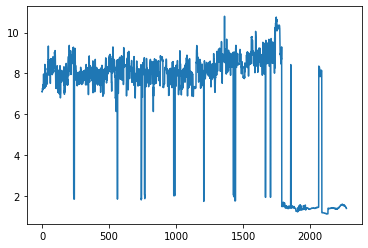

In [51]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [52]:
ga = np.array(ga)
ba = np.array(ba)

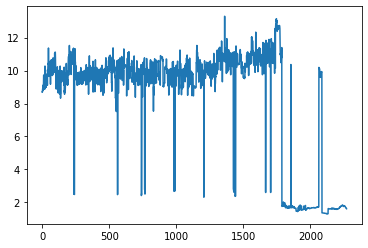

In [53]:
plt.plot(ga)

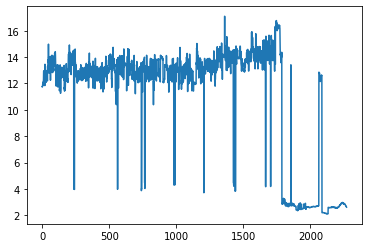

In [54]:
plt.plot(ba)

In [57]:
#normalize over 30s windows as in Poe et al.
n30 = int((n_frames - 900)/30) #number of 30 second sliding windows
ran = np.zeros(n30*30)
gan = np.zeros(n30*30)
ban = np.zeros(n30*30)
for i in range(n30):
  rav = np.mean(ra[i*30:i*30+900])
  gav = np.mean(ga[i*30:i*30+900])
  bav = np.mean(ba[i*30:i*30+900])
  rstd = np.std(ra[i*30:i*30+900])
  gstd = np.std(ga[i*30:i*30+900])
  bstd = np.std(ba[i*30:i*30+900])
  for j in range(30):
    ran[i*30+ j] = (ra[i*30 + j] - rav)/rstd
    gan[i*30+ j] = (ga[i*30 + j] - gav)/gstd
    ban[i*30+ j] = (ba[i*30 + j] - bav)/bstd


IndexError: ignored

In [60]:
n30

45

In [ ]:
plt.plot(ran)

In [ ]:
plt.plot(gan)

In [ ]:
plt.plot(ban)

In [61]:
X = np.array(list(zip(ra,ga,ba)))

In [62]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=3)

In [63]:
X_transformed = transformer.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [64]:
X_indep = X_transformed.transpose()

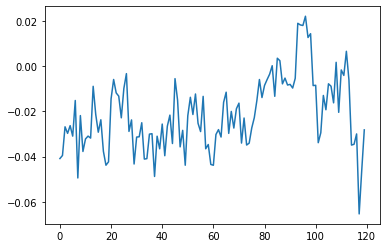

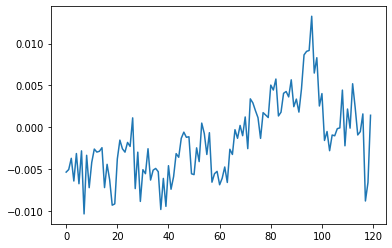

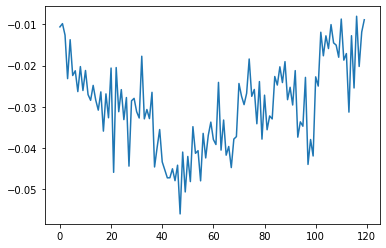

In [65]:
plt.plot(X_indep[0][:120])
plt.show()
plt.plot(X_indep[1][:120])
plt.show()
plt.plot(X_indep[2][:120])
plt.show()

In [66]:
from scipy import signal
x1 = X_indep[1] - X_indep[1].mean()
x1_corr = signal.correlate(x1, x1, mode='same')

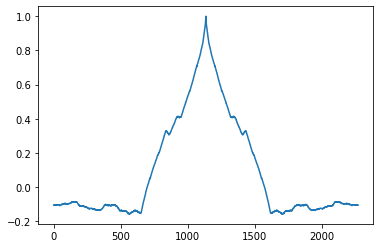

In [67]:

plt.plot(x1_corr)

In [68]:
ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])

In [69]:
fs_n = 30/len(x1_corr/2)

In [70]:
upper = int(4/fs_n)

In [71]:
lower = int(0.75/fs_n)

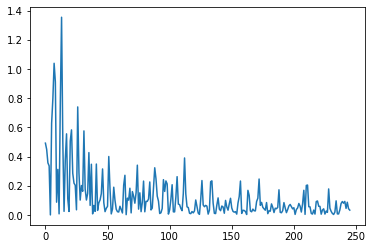

In [72]:
plt.plot((abs(ff[lower:upper])))

In [73]:
(np.argmax(abs(ff[lower:upper])) + lower)*60*fs_n

54.689564068692206

In [74]:
np.max(abs(ff[lower:upper]))

1.3543253167282314

In [75]:
from scipy.stats import kurtosis as kurt

In [76]:
x2 = X_indep[2] - X_indep[2].mean()
x2_corr = signal.correlate(x2, x2, mode='same')

In [77]:

ff = np.fft.hfft(x2_corr[:int(len(x2_corr)/2)])

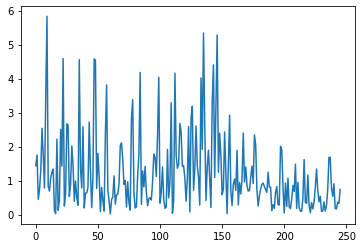

In [78]:
plt.plot((abs(ff[lower:upper])))

In [79]:

(np.argmax(abs(ff[lower:upper])) + lower)*60*fs_n

51.51915455746367

In [80]:
np.max(abs(ff[lower:upper]))

5.833500934258803

In [81]:
x0 = X_indep[0] - X_indep[0].mean()
x0_corr = signal.correlate(x0, x0, mode='same')

In [82]:
ff = np.fft.hfft(x0_corr[:int(len(x0_corr)/2)])

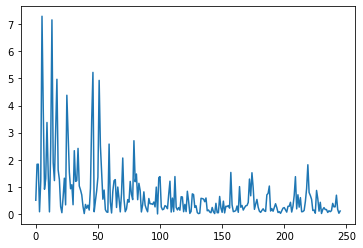

In [83]:
plt.plot((abs(ff[lower:upper])))

In [84]:
(np.argmax(abs(ff[lower:upper])) + lower)*60*fs_n

48.34874504623514

In [ ]:
np.max(abs(ff[lower:upper]))